#**Financial Fraud Detection using GAN, XGBoost, SMOTE**





#Step 1: Imports


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, classification_report)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import joblib


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def safe_tensor(tensor):
    tensor = tensor.clone()
    tensor[torch.isnan(tensor)] = 0
    tensor[torch.isinf(tensor)] = 0
    return tensor.float()


## Step 2: Load + Preprocess Data


In [4]:
batch_size = 50000
data_iter = pd.read_csv('/content/drive/MyDrive/credit_card_transactions.csv', chunksize=batch_size)
data_list = []

for chunk in data_iter:
    chunk.drop(['Unnamed: 0', 'trans_num', 'first', 'last', 'street', 'job'], axis=1, inplace=True)
    chunk['dob'] = chunk['dob'].fillna('1900-01-01')
    chunk['unix_time'] = chunk['unix_time'].fillna(chunk['unix_time'].mean())
    chunk['merch_lat'] = chunk['merch_lat'].fillna(chunk['merch_lat'].mean())
    chunk['merch_long'] = chunk['merch_long'].fillna(chunk['merch_long'].mean())
    chunk['is_fraud'] = chunk['is_fraud'].fillna(0)
    chunk['merch_zipcode'] = chunk['merch_zipcode'].fillna(0)
    chunk['age'] = 2025 - pd.to_datetime(chunk['dob'], errors='coerce').dt.year.fillna(1900)
    chunk.drop('dob', axis=1, inplace=True)
    chunk['merchant_freq'] = chunk['merchant'].map(chunk['merchant'].value_counts())
    chunk['city_freq'] = chunk['city'].map(chunk['city'].value_counts())
    chunk.drop(['merchant', 'city'], axis=1, inplace=True)
    chunk = pd.get_dummies(chunk, columns=['category', 'gender', 'state'])
    chunk['trans_date_trans_time'] = pd.to_datetime(chunk['trans_date_trans_time'], errors='coerce')
    chunk['trans_date_trans_time'] = chunk['trans_date_trans_time'].astype('int64') // 10**9
    chunk = chunk.apply(pd.to_numeric, errors='coerce').fillna(0)
    data_list.append(chunk)

data = pd.concat(data_list, ignore_index=True)
labels = data['is_fraud'].values
data.drop('is_fraud', axis=1, inplace=True)


## Step 3: Normalize and Split


In [5]:
scaler = MinMaxScaler()
scaled_data_np = scaler.fit_transform(data)
scaled_data = safe_tensor(torch.tensor(scaled_data_np)).to(device)
labels = safe_tensor(torch.tensor(labels).unsqueeze(1)).to(device)
joblib.dump(scaler, 'minmax_scaler.pkl')

X_train, X_test, y_train, y_test = train_test_split(scaled_data, labels, test_size=0.2, shuffle=True)

## Step 4: SMOTE


In [6]:
X_train_np = X_train.cpu().numpy()
y_train_np = y_train.cpu().numpy().ravel()
X_train_np = SimpleImputer(strategy='mean').fit_transform(X_train_np)
X_smote, y_smote = SMOTE().fit_resample(X_train_np, y_train_np)
X_smote = safe_tensor(torch.tensor(X_smote)).to(device)
y_smote = safe_tensor(torch.tensor(y_smote).unsqueeze(1)).to(device)



## Step 5: Define Models


In [7]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
generator = Generator(input_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

loss_fn = nn.BCELoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0005)

## Step 6: Train GAN with Label Smoothing + Flipping


In [8]:
epochs = 800
batch_size = 1024
gen_losses, disc_losses = [], []

for epoch in range(epochs):
    perm = torch.randperm(len(X_train))
    X_train = X_train[perm]

    for i in range(0, len(X_train), batch_size):
        real_batch = X_train[i:i+batch_size].to(device)
        noise = torch.randn(real_batch.size(0), input_dim).to(device)
        fake_batch = generator(noise)

        # Label smoothing
        real_labels = torch.empty((real_batch.size(0), 1), device=device).uniform_(0.8, 1.0)
        fake_labels = torch.zeros((real_batch.size(0), 1), device=device)

        # Random label flipping
        if np.random.rand() < 0.05:
            real_labels, fake_labels = fake_labels, real_labels

        # Train Discriminator
        disc_optimizer.zero_grad()
        real_loss = loss_fn(discriminator(real_batch), real_labels)
        fake_loss = loss_fn(discriminator(fake_batch.detach()), fake_labels)
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        disc_optimizer.step()

        # Train Generator
        gen_optimizer.zero_grad()
        gen_loss = loss_fn(discriminator(fake_batch), torch.ones_like(real_labels))  # fool the discriminator
        penalty = torch.mean((fake_batch.mean(dim=0) - real_batch.mean(dim=0))**2)
        total_gen_loss = gen_loss + 0.1 * penalty
        total_gen_loss.backward()
        gen_optimizer.step()

        gen_losses.append(gen_loss.item())
        disc_losses.append(disc_loss.item())

    print(f"Epoch {epoch+1}/{epochs} - Gen Loss: {gen_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

Epoch 1/800 - Gen Loss: 1.3456, Disc Loss: 0.8555
Epoch 2/800 - Gen Loss: 3.2127, Disc Loss: 0.4752
Epoch 3/800 - Gen Loss: 1.9849, Disc Loss: 0.6511
Epoch 4/800 - Gen Loss: 2.1791, Disc Loss: 0.5558
Epoch 5/800 - Gen Loss: 2.8274, Disc Loss: 0.5344
Epoch 6/800 - Gen Loss: 2.1381, Disc Loss: 0.5624
Epoch 7/800 - Gen Loss: 3.1929, Disc Loss: 0.4724
Epoch 8/800 - Gen Loss: 2.1453, Disc Loss: 0.7417
Epoch 9/800 - Gen Loss: 1.6236, Disc Loss: 0.7259
Epoch 10/800 - Gen Loss: 1.5454, Disc Loss: 0.5410
Epoch 11/800 - Gen Loss: 2.6711, Disc Loss: 0.4557
Epoch 12/800 - Gen Loss: 2.5441, Disc Loss: 0.4984
Epoch 13/800 - Gen Loss: 2.4199, Disc Loss: 0.5142
Epoch 14/800 - Gen Loss: 3.0316, Disc Loss: 0.5324
Epoch 15/800 - Gen Loss: 3.1511, Disc Loss: 0.4646
Epoch 16/800 - Gen Loss: 4.2161, Disc Loss: 0.5014
Epoch 17/800 - Gen Loss: 4.0545, Disc Loss: 0.3888
Epoch 18/800 - Gen Loss: 2.2894, Disc Loss: 0.4868
Epoch 19/800 - Gen Loss: 2.4995, Disc Loss: 0.6024
Epoch 20/800 - Gen Loss: 3.9420, Disc Lo

## Step 7: Plot Smoothed Losses


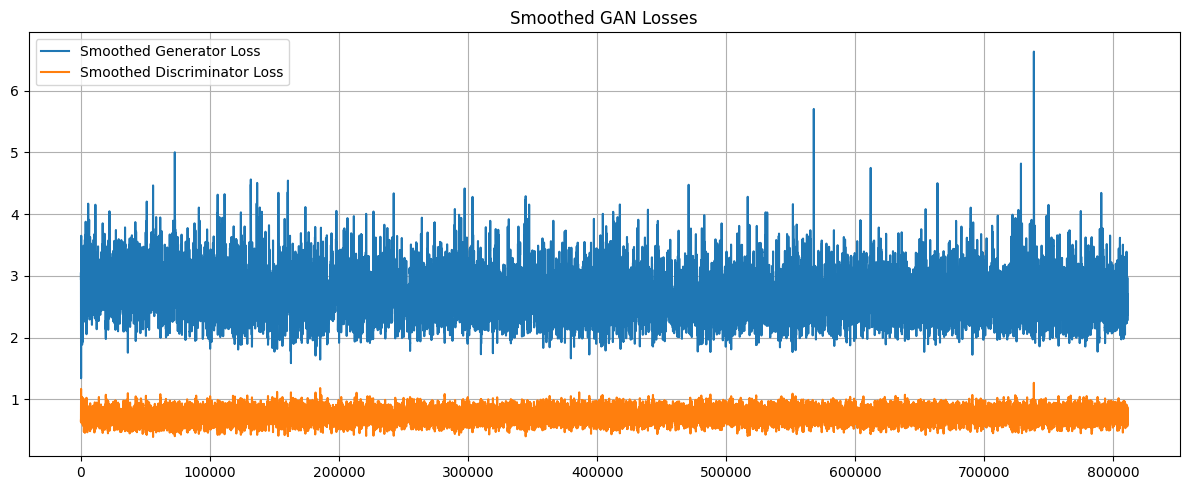

In [9]:
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 5))
plt.plot(moving_average(gen_losses), label='Smoothed Generator Loss')
plt.plot(moving_average(disc_losses), label='Smoothed Discriminator Loss')
plt.legend()
plt.title('Smoothed GAN Losses')
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 8: Discriminator Score Histogram


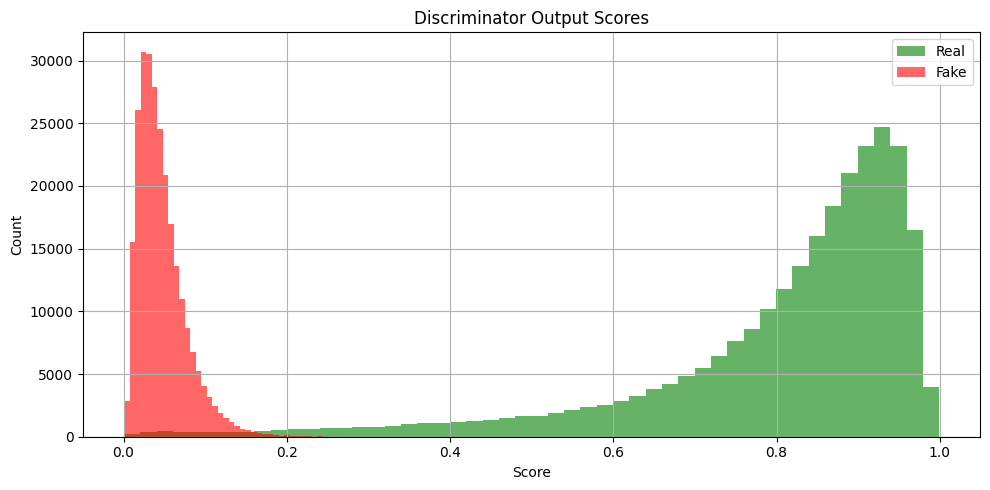

In [10]:
with torch.no_grad():
    real_scores = discriminator(X_test.to(device)).cpu().numpy().flatten()
    fake_scores = discriminator(generator(torch.randn(len(X_test), input_dim).to(device))).cpu().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.hist(real_scores, bins=50, alpha=0.6, label='Real', color='green')
plt.hist(fake_scores, bins=50, alpha=0.6, label='Fake', color='red')
plt.title('Discriminator Output Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 9: Train XGBoost Classifier


In [11]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_clf.fit(X_smote.cpu().numpy(), y_smote.cpu().numpy())

y_pred = xgb_clf.predict(X_test.cpu().numpy())
y_prob = xgb_clf.predict_proba(X_test.cpu().numpy())[:, 1]

print("\n🔍 Classification Report:\n")
print(classification_report(y_test.cpu().numpy(), y_pred, target_names=["Not Fraud", "Fraud"]))
print(f"✅ Accuracy: {accuracy_score(y_test.cpu().numpy(), y_pred):.4f}")
print(f"✅ Precision: {precision_score(y_test.cpu().numpy(), y_pred):.4f}")
print(f"✅ Recall: {recall_score(y_test.cpu().numpy(), y_pred):.4f}")
print(f"✅ F1 Score: {f1_score(y_test.cpu().numpy(), y_pred):.4f}")
print(f"✅ ROC AUC: {roc_auc_score(y_test.cpu().numpy(), y_prob):.4f}")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:26:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Classification Report:

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    257854
       Fraud       0.33      0.91      0.48      1481

    accuracy                           0.99    259335
   macro avg       0.66      0.95      0.74    259335
weighted avg       1.00      0.99      0.99    259335

✅ Accuracy: 0.9889
✅ Precision: 0.3299
✅ Recall: 0.9082
✅ F1 Score: 0.4840
✅ ROC AUC: 0.9941


# Step 10: Save Models


In [12]:
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')
joblib.dump(xgb_clf, 'xgboost_model.pkl')

['xgboost_model.pkl']

## Step 11: Test Individual Transaction by Index



In [17]:
def test_transaction_by_index(index):
    raw_df = pd.read_csv('/content/drive/MyDrive/credit_card_transactions.csv')
    raw_df.drop(['Unnamed: 0', 'trans_num', 'first', 'last', 'street', 'job'], axis=1, inplace=True)
    raw_df['dob'] = raw_df['dob'].fillna('1900-01-01')
    raw_df['unix_time'] = raw_df['unix_time'].fillna(raw_df['unix_time'].mean())
    raw_df['merch_lat'] = raw_df['merch_lat'].fillna(raw_df['merch_lat'].mean())
    raw_df['merch_long'] = raw_df['merch_long'].fillna(raw_df['merch_long'].mean())
    raw_df['is_fraud'] = raw_df['is_fraud'].fillna(0)
    raw_df['merch_zipcode'] = raw_df['merch_zipcode'].fillna(0)
    raw_df['age'] = 2025 - pd.to_datetime(raw_df['dob'], errors='coerce').dt.year.fillna(1900)
    raw_df.drop('dob', axis=1, inplace=True)
    raw_df['merchant_freq'] = raw_df['merchant'].map(raw_df['merchant'].value_counts())
    raw_df['city_freq'] = raw_df['city'].map(raw_df['city'].value_counts())
    raw_df.drop(['merchant', 'city'], axis=1, inplace=True)
    raw_df = pd.get_dummies(raw_df, columns=['category', 'gender', 'state'])
    raw_df['trans_date_trans_time'] = pd.to_datetime(raw_df['trans_date_trans_time'], errors='coerce')
    raw_df['trans_date_trans_time'] = raw_df['trans_date_trans_time'].astype('int64') // 10**9
    raw_df = raw_df.apply(pd.to_numeric, errors='coerce').fillna(0)

    sample = raw_df.iloc[[index]].drop('is_fraud', axis=1)
    true_label = raw_df.iloc[index]['is_fraud']

    # Align columns with training data
    for col in data.columns:
        if col not in sample.columns:
            sample[col] = 0
    sample = sample[data.columns]  # Reorder columns

    # Scale and convert to tensor
    scaler = joblib.load('minmax_scaler.pkl')
    sample_scaled = scaler.transform(sample)
    sample_tensor = safe_tensor(torch.tensor(sample_scaled)).to(device)

    # Predict
    xgb_model = joblib.load('xgboost_model.pkl')
    prob = xgb_model.predict_proba(sample_tensor.cpu().numpy())[:, 1][0]
    prediction = xgb_model.predict(sample_tensor.cpu().numpy())[0]

    print(f"\n🧪 Transaction Index: {index}")
    print(f"🕵️ True Label: {'FRAUD' if true_label == 1 else 'NOT FRAUD'}")
    print(f"🤖 Model Prediction: {'FRAUD' if prediction == 1 else 'NOT FRAUD'}")
    print(f"📈 Probability of Fraud: {prob:.4f}")

# Example usage
test_transaction_by_index(2937)  # Replace 1234 with your test index



🧪 Transaction Index: 2937
🕵️ True Label: FRAUD
🤖 Model Prediction: FRAUD
📈 Probability of Fraud: 0.9216


In [18]:
## Step 11: Test Individual Transaction by Index
def test_transaction_by_index(index):
    raw_df = pd.read_csv('/content/drive/MyDrive/credit_card_transactions.csv')
    raw_df.drop(['Unnamed: 0', 'trans_num', 'first', 'last', 'street', 'job'], axis=1, inplace=True)
    raw_df['dob'] = raw_df['dob'].fillna('1900-01-01')
    raw_df['unix_time'] = raw_df['unix_time'].fillna(raw_df['unix_time'].mean())
    raw_df['merch_lat'] = raw_df['merch_lat'].fillna(raw_df['merch_lat'].mean())
    raw_df['merch_long'] = raw_df['merch_long'].fillna(raw_df['merch_long'].mean())
    raw_df['is_fraud'] = raw_df['is_fraud'].fillna(0)
    raw_df['merch_zipcode'] = raw_df['merch_zipcode'].fillna(0)
    raw_df['age'] = 2025 - pd.to_datetime(raw_df['dob'], errors='coerce').dt.year.fillna(1900)
    raw_df.drop('dob', axis=1, inplace=True)
    raw_df['merchant_freq'] = raw_df['merchant'].map(raw_df['merchant'].value_counts())
    raw_df['city_freq'] = raw_df['city'].map(raw_df['city'].value_counts())
    raw_df.drop(['merchant', 'city'], axis=1, inplace=True)
    raw_df = pd.get_dummies(raw_df, columns=['category', 'gender', 'state'])
    raw_df['trans_date_trans_time'] = pd.to_datetime(raw_df['trans_date_trans_time'], errors='coerce')
    raw_df['trans_date_trans_time'] = raw_df['trans_date_trans_time'].astype('int64') // 10**9
    raw_df = raw_df.apply(pd.to_numeric, errors='coerce').fillna(0)

    sample = raw_df.iloc[[index]].drop('is_fraud', axis=1)
    true_label = raw_df.iloc[index]['is_fraud']

    # Align columns with training data
    for col in data.columns:
        if col not in sample.columns:
            sample[col] = 0
    sample = sample[data.columns]  # Reorder columns

    # Scale and convert to tensor
    scaler = joblib.load('minmax_scaler.pkl')
    sample_scaled = scaler.transform(sample)
    sample_tensor = safe_tensor(torch.tensor(sample_scaled)).to(device)

    # Predict
    xgb_model = joblib.load('xgboost_model.pkl')
    prob = xgb_model.predict_proba(sample_tensor.cpu().numpy())[:, 1][0]
    prediction = xgb_model.predict(sample_tensor.cpu().numpy())[0]

    print(f"\n🧪 Transaction Index: {index}")
    print(f"🕵️ True Label: {'FRAUD' if true_label == 1 else 'NOT FRAUD'}")
    print(f"🤖 Model Prediction: {'FRAUD' if prediction == 1 else 'NOT FRAUD'}")
    print(f"📈 Probability of Fraud: {prob:.4f}")

# Example usage
test_transaction_by_index(4324)  # Replace 1234 with your test index



🧪 Transaction Index: 4324
🕵️ True Label: FRAUD
🤖 Model Prediction: FRAUD
📈 Probability of Fraud: 0.9954


In [19]:
## Step 11: Test Individual Transaction by Index
def test_transaction_by_index(index):
    raw_df = pd.read_csv('/content/drive/MyDrive/credit_card_transactions.csv')
    raw_df.drop(['Unnamed: 0', 'trans_num', 'first', 'last', 'street', 'job'], axis=1, inplace=True)
    raw_df['dob'] = raw_df['dob'].fillna('1900-01-01')
    raw_df['unix_time'] = raw_df['unix_time'].fillna(raw_df['unix_time'].mean())
    raw_df['merch_lat'] = raw_df['merch_lat'].fillna(raw_df['merch_lat'].mean())
    raw_df['merch_long'] = raw_df['merch_long'].fillna(raw_df['merch_long'].mean())
    raw_df['is_fraud'] = raw_df['is_fraud'].fillna(0)
    raw_df['merch_zipcode'] = raw_df['merch_zipcode'].fillna(0)
    raw_df['age'] = 2025 - pd.to_datetime(raw_df['dob'], errors='coerce').dt.year.fillna(1900)
    raw_df.drop('dob', axis=1, inplace=True)
    raw_df['merchant_freq'] = raw_df['merchant'].map(raw_df['merchant'].value_counts())
    raw_df['city_freq'] = raw_df['city'].map(raw_df['city'].value_counts())
    raw_df.drop(['merchant', 'city'], axis=1, inplace=True)
    raw_df = pd.get_dummies(raw_df, columns=['category', 'gender', 'state'])
    raw_df['trans_date_trans_time'] = pd.to_datetime(raw_df['trans_date_trans_time'], errors='coerce')
    raw_df['trans_date_trans_time'] = raw_df['trans_date_trans_time'].astype('int64') // 10**9
    raw_df = raw_df.apply(pd.to_numeric, errors='coerce').fillna(0)

    sample = raw_df.iloc[[index]].drop('is_fraud', axis=1)
    true_label = raw_df.iloc[index]['is_fraud']

    # Align columns with training data
    for col in data.columns:
        if col not in sample.columns:
            sample[col] = 0
    sample = sample[data.columns]  # Reorder columns

    # Scale and convert to tensor
    scaler = joblib.load('minmax_scaler.pkl')
    sample_scaled = scaler.transform(sample)
    sample_tensor = safe_tensor(torch.tensor(sample_scaled)).to(device)

    # Predict
    xgb_model = joblib.load('xgboost_model.pkl')
    prob = xgb_model.predict_proba(sample_tensor.cpu().numpy())[:, 1][0]
    prediction = xgb_model.predict(sample_tensor.cpu().numpy())[0]

    print(f"\n🧪 Transaction Index: {index}")
    print(f"🕵️ True Label: {'FRAUD' if true_label == 1 else 'NOT FRAUD'}")
    print(f"🤖 Model Prediction: {'FRAUD' if prediction == 1 else 'NOT FRAUD'}")
    print(f"📈 Probability of Fraud: {prob:.4f}")

# Example usage
test_transaction_by_index(1)  # Replace 1234 with your test index



🧪 Transaction Index: 1
🕵️ True Label: NOT FRAUD
🤖 Model Prediction: NOT FRAUD
📈 Probability of Fraud: 0.0049
